# Evaluating Answers
                

In [1]:
from commonfunctions import *
from skimage.transform import resize



%matplotlib inline
%load_ext autoreload
%autoreload 2

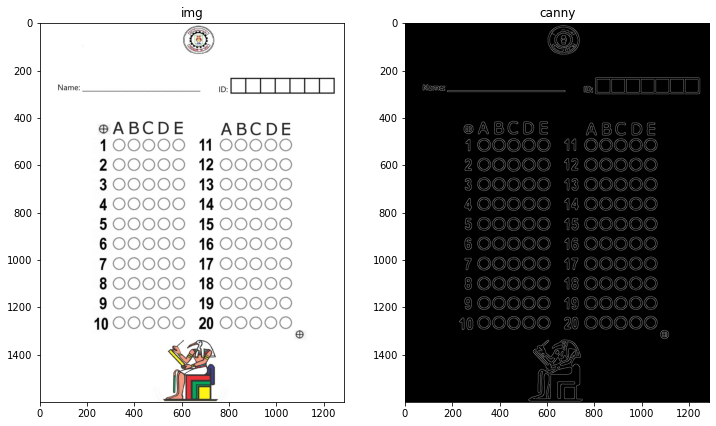

x centers [ 784  784  333  333  973  784  333  333  458  973 1036 1036  333 1036
  396  847  973  333  458  973  973 1036  458  522  973 1036  522  522
  784  522  847  784  396  847  522  585  333  522  522  909  585  909
  973  784  909  847  585  585  585  522  847  973  458  333  396  973
  522  847  909  973  847  333  784  847  784  458 1036  333  909  909
  396  847  396  458  522  396  585  847  458  784  396  784  396  909
  396  396  458  585  910 1036 1036  910 1036  458  396 1036  458 1036
 1036  584]
y centers [1015  680 1015  597  763  597  680 1099  598 1265 1099 1015  763  680
  597  763  848  514 1016 1099 1182  763  681  514  514  597  597  680
  514  763  680  763 1015 1015 1099 1099 1182 1182 1015  598  680  681
  930 1099 1016 1099 1015  597  763  930  514 1015 1100  930  680  680
 1265 1182 1100  597  597 1265 1182  930  930  515  514  848  515  764
 1099 1265 1182  931  848  763  514  848  764 1265 1265  848  514  931
  514  930 1266  930  848  848 1265 1265 1182

C:\Users\Otrebor Azilab\AppData\Local\Temp/ipykernel_8248/2928111776.py:14: FutureWarning: Pass-through of possibly RGB images in gray2rgb is deprecated. In version 0.19, input arrays will always be considered grayscale, even if the last dimension has length 3 or 4. To prevent this warning and ensure compatibility with future versions, detect RGB images outside of this function.
  image = gray2rgb(image)


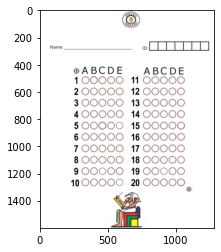

In [2]:
image=io.imread("bubbles_final_unsolved.jpg")
img_canny=canny(rgb2gray(image),3)
show_images([image,img_canny],["img","canny"])

hough_radii = np.arange(25, 30, 1)
hough_res = hough_circle(img_canny, hough_radii)
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,total_num_peaks=100)

print("x centers",cx)
print("y centers",cy)
print("radii",radii)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image = gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=image.shape)
    image[circy, circx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()

#(houghSpace,angles, distances) = hough_line_peaks(hspace=houghSpace1,angles = angles1, dists= distances1,threshold=int(0.5*np.max(houghSpace1)))

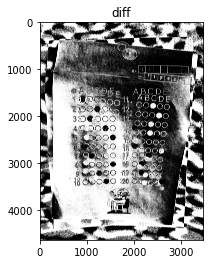

In [3]:
answers= loadImage('solved_images/1.jpg')
ref= loadImage('solved_images/5.jpg')
diff = ref - answers
thresh = threshold_otsu(diff)
diff=diff > thresh
answers_closing = closing(diff,np.ones((3,3),dtype=int))

show_images([diff],["diff"])

In [4]:
#initial pipeline

#load reference image and crop/segment
cross_template = loadImage("digital_images/bubble_w_cross.png")
bubbles_w_cross=loadImage("digital_images/bubbles_empty_with_cross.jpeg")
print(bubbles_w_cross.shape)
out_ref = crop_answers_section(bubbles_w_cross)
ref_shape = out_ref.shape

ref_chunck1 =out_ref[:,0:370]  #seg bel 7ob
ref_chunck2 =out_ref[:,450:]
thresh1 = threshold_otsu(ref_chunck1)
thresh2 = threshold_otsu(ref_chunck2)
ref_chunck1 = ref_chunck1 > thresh1
ref_chunck2 = ref_chunck2 > thresh2
#show_images([ref_chunck1,ref_chunck2])

circles_chunck1 = Hough(ref_chunck1) 
circles_chunck2 = Hough(ref_chunck2)       

coordinates_chunk1 = show_Hough(ref_chunck1,circles_chunck1)
coordinates_chunk2 = show_Hough(ref_chunck2,circles_chunck2)


print(coordinates_chunk1.shape)
print(coordinates_chunk2.shape)



C:\Users\Otrebor Azilab\Desktop\Senior2 21-22\Sem1\Image and cv\Project\Bubble-Sheet-Corrector\Playground\Evaluate_Answers\commonfunctions.py:47: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  image = (rgb2gray(image)*255).astype('uint8')


(1600, 1286)
(50, 3)
(50, 3)


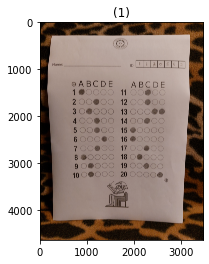

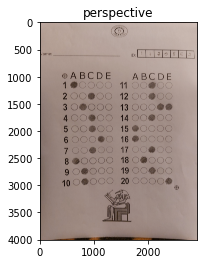

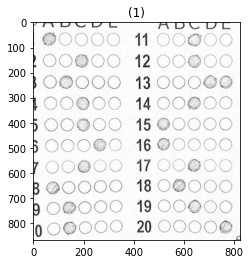

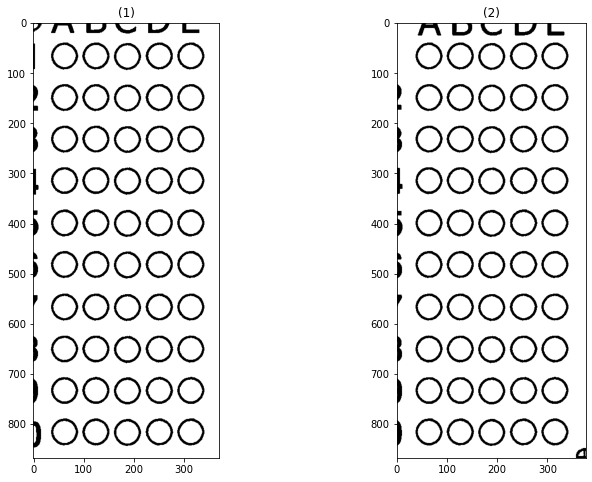

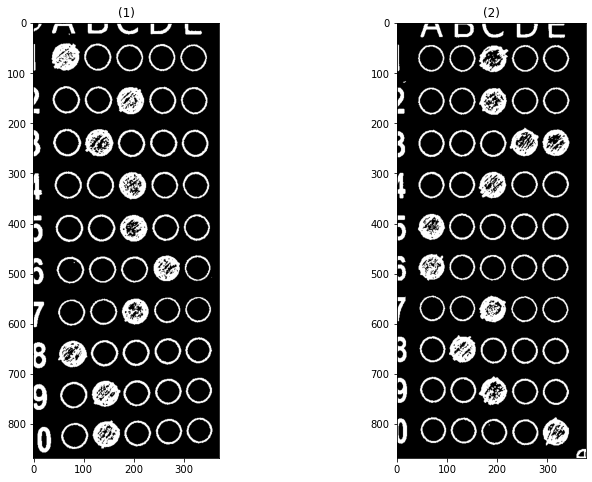

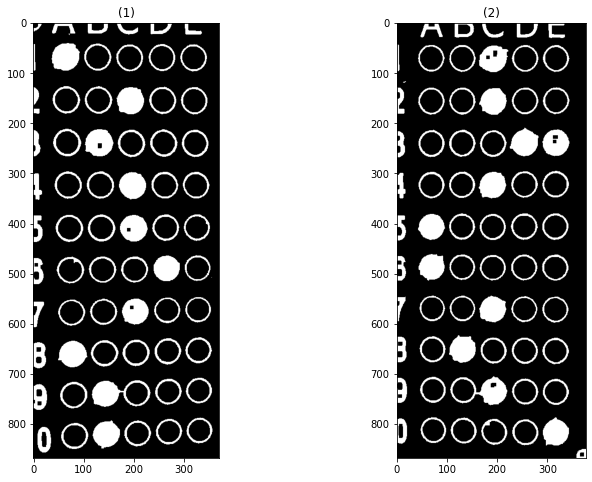

(868, 370) (868, 377) (868, 370) (868, 377)


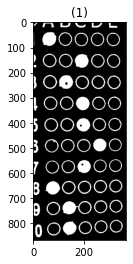

In [5]:
##
# for the answer image:
##
# working imgs solved_images/{1,2,3}.jpg
# load it and correct its perspective:
answers = io.imread("solved_images/3.jpg") 
show_images([answers])
answers,_ = perspective_correction(answers)
show_images([answers],["perspective"])


paper_gray = rgb2gray(answers)*255
paper_gray_resized = resize(paper_gray,(1600,1286))
paper_gray_resized = paper_gray_resized.astype("uint8")

paper_gray_resized = removeShadowGray(paper_gray_resized)
out_ans = crop_answers_section(paper_gray_resized)

out_ans = resize(out_ans,ref_shape) 
out_ans = removeShadowGray((out_ans*255).astype("uint8"))
show_images([out_ans])

ans_chunck1 =out_ans[:,0:370]  #seg bel 7ob
ans_chunck2 =out_ans[:,450:]

# resize chunks to match
ans_chunck1 = resize(ans_chunck1,ref_chunck1.shape)
ans_chunck2 = resize(ans_chunck2,ref_chunck2.shape)

##thresholding
#thresh1 = threshold_otsu(ans_chunck1)
#thresh2 = threshold_otsu(ans_chunck2)
#print(thresh1)

thresh1=240/255
thresh2=240/255

ans_chunck1 = (ans_chunck1 < thresh1)

ans_chunck2 =(ans_chunck2 < thresh2)

show_images([ref_chunck1,ref_chunck2])
show_images([ans_chunck1,ans_chunck2])
ans_chunck1 = binary_closing(ans_chunck1, np.ones((7,7), np.uint8))
ans_chunck2 = binary_closing(ans_chunck2, np.ones((7,7), np.uint8))
show_images([ans_chunck1,ans_chunck2])

print(ans_chunck1.shape,ans_chunck2.shape,ref_chunck1.shape,ref_chunck2.shape)

# diff1 = ref_chunck1 ^ ans_chunck1
# diff2 = ref_chunck2 ^ ans_chunck2

#ans_chunck1 = ~ans_chunck1
#ans_chunck2 = ~ans_chunck2
# print(diff1)
# show_images([diff1,diff2])
show_images([ans_chunck1])


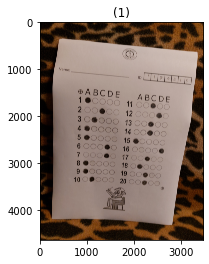

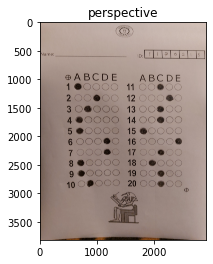

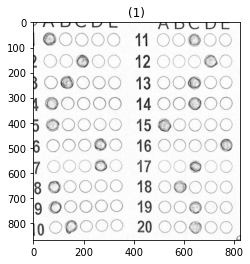

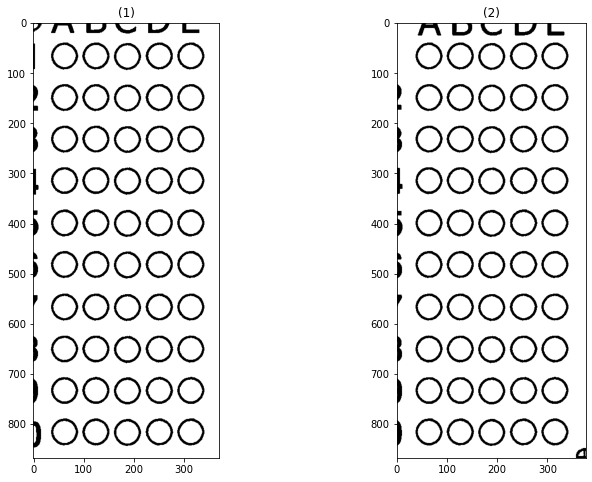

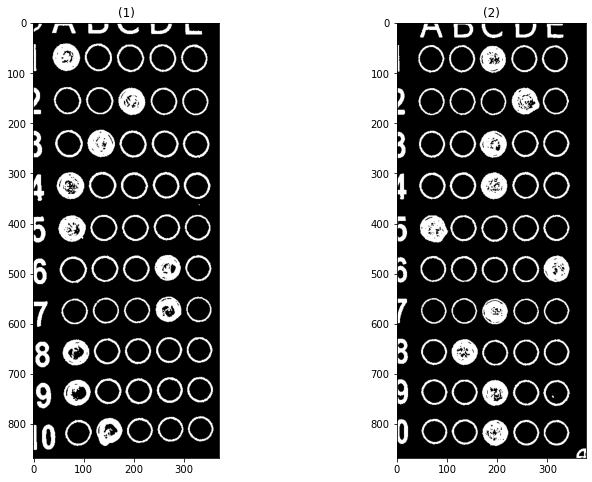

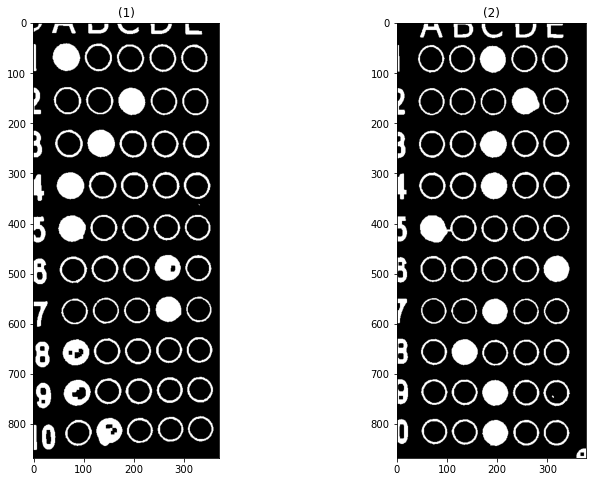

(868, 370) (868, 377) (868, 370) (868, 377)


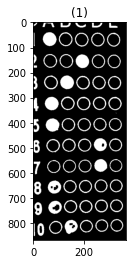

<Figure size 432x288 with 0 Axes>

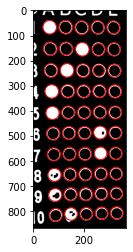

50


<Figure size 432x288 with 0 Axes>

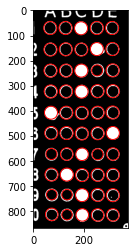

50
[[[ 22  67 261]
  [ 25  67 260]
  [ 25  67 268]
  [ 25  68 328]
  [ 25  69 330]]

 [[ 25 152 331]
  [ 25 153 332]
  [ 25 155 272]
  [ 25 155 211]
  [ 25 157 150]]

 [[ 26 239 256]
  [ 26 239 319]
  [ 26 240 130]
  [ 26 240 321]
  [ 26 240 323]]

 [[ 26 322 263]
  [ 26 322 200]
  [ 26 323 325]
  [ 26 323 265]
  [ 26 323 139]]

 [[ 26 406 202]
  [ 26 407 326]
  [ 26 407  76]
  [ 26 407 266]
  [ 26 409 327]]

 [[ 26 487 142]
  [ 26 488 204]
  [ 26 489  79]
  [ 26 489 144]
  [ 26 491 206]]

 [[ 26 570  81]
  [ 26 570 269]
  [ 26 572 207]
  [ 26 572 146]
  [ 26 574  84]]

 [[ 26 651 271]
  [ 26 651 148]
  [ 26 653 209]
  [ 26 654  87]
  [ 26 656  89]]

 [[ 27 730  65]
  [ 27 731 129]
  [ 27 733 193]
  [ 27 733  67]
  [ 27 736 195]]

 [[ 27 808  70]
  [ 27 809 134]
  [ 27 811 198]
  [ 27 812 137]
  [ 27 816  73]]]


ValueError: could not broadcast input array from shape (0,) into shape (5,)

In [6]:
i = 5
#try:
ans = getFinalAnswers(io.imread('solved_images/'+ str(i) +'.jpg'), correctPerspective=True, showInfo=True)[2]
print(str(i)+': ', list(ans))
idd = get_id(io.imread('solved_images/'+ str(i) +'.jpg'), id_length=7, show_info=False, correct_perspective=True)
print(str(i)+': ', idd)

#except:
#    print('Error in ' + str(i))

In [ ]:
# check {4}
ii = [1,2,3,4,5,6,7,8,9,10]
for i in ii:
    try:
        ans = getFinalAnswers(io.imread('solved_images/'+ str(i) +'.jpg'), correctPerspective=True, showInfo=False)[2]
        print(str(i)+': ', list(ans))
        idd = get_id(io.imread('solved_images/'+ str(i) +'.jpg'), id_length=7, show_info=False, correct_perspective=True)
        print(str(i)+': ', idd)
        
    except:
        print('Error in ' + str(i))

In [ ]:
##
# for the answer image:
##
# working imgs solved_images/{1,2,3}.jpg
# load it and correct its perspective:



In [ ]:
circles_chunck1 = Hough(ans_chunck1) 
circles_chunck2 = Hough(ans_chunck2)   

coordinates_chunk1 = show_Hough(ans_chunck1,circles_chunck1,show_info=True)
coordinates_chunk2 = show_Hough(ans_chunck2,circles_chunck2,show_info=True)

In [44]:
modelAnwsers = loadModelAnswer('Model_answer.txt')

chunkAnswers1 = getAnswers(coordinates_chunk1,ans_chunck1)
chunkAnswers2 = getAnswers(coordinates_chunk2,ans_chunck2)

modelAnwsers = np.array(modelAnwsers)
currAnswers = np.concatenate((chunkAnswers1, chunkAnswers2))

print('Model answers: ',modelAnwsers)
print('Current answers: ',currAnswers)
grade = (modelAnwsers == currAnswers)

print('Grade: ' + str(grade.sum()) + '/' + str(len(grade)))


Model answers:  [1 2 3 4 5 4 3 2 3 4 2 2 3 3 3 2 2 1 1 4]
Current answers:  [ 1  3  2  3  3  4  3  1  2  2  3  3 -1  3  1  1  3  2  3  5]
Grade: 4/20


Number of contours:81
Number of contours:11


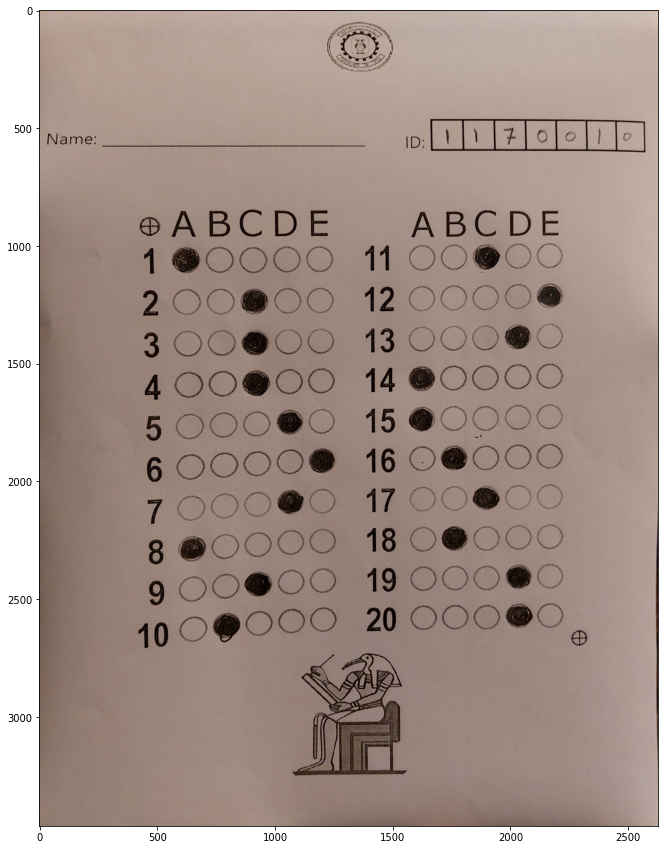

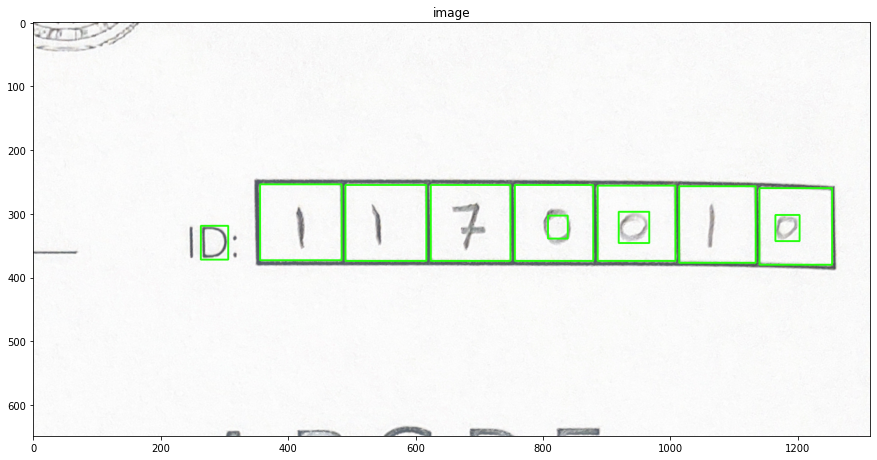

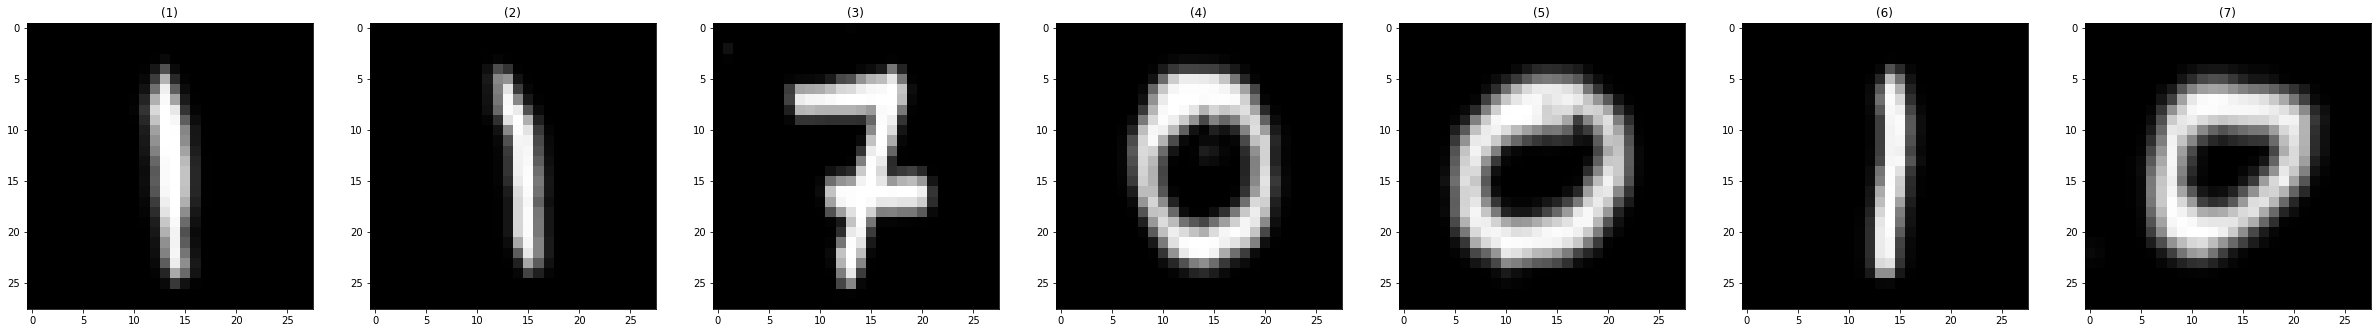

1170010


In [7]:
#get ID
image = io.imread('solved_images/4.jpg')
plt.figure(figsize=(15, 15)); plt.imshow(perspective_correction(image)[0])
idd = get_id(image, id_length=7, show_info=True, correct_perspective=True)
print(idd)

In [55]:
id = 1170517
currAnswers = currAnswers.tolist()
currAnswers.insert(0,id)
number_questions = len(currAnswers)-1


In [56]:
Qs =[]
Qs.append("ID")

for i in range(number_questions):
    Qs.append('Q'+str(i+1))

Qs=tuple(Qs)

# excel filling 

grades = load_workbook('excel/grades.xlsx')

grades_sheet = grades['grades']

 

grades_tuple= tuple(currAnswers)
print(grades_tuple)

grades_sheet.append(Qs)
grades_sheet.append(grades_tuple)

grades.save('excel/grades.xlsx')
print(grades.active)



(1170517, 2, 4, 2, -1, 5, -1, 2, 5, 2, 2, 3, 4, 2, 3, 1, 1, 3, 2, 3, 5)
<Worksheet "grades">


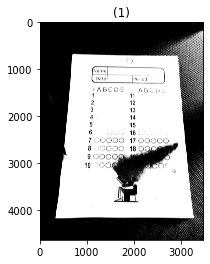

4
(3503, 2927)
(4624, 3472, 3)
(1600, 1286, 3)
<class 'numpy.uint8'>


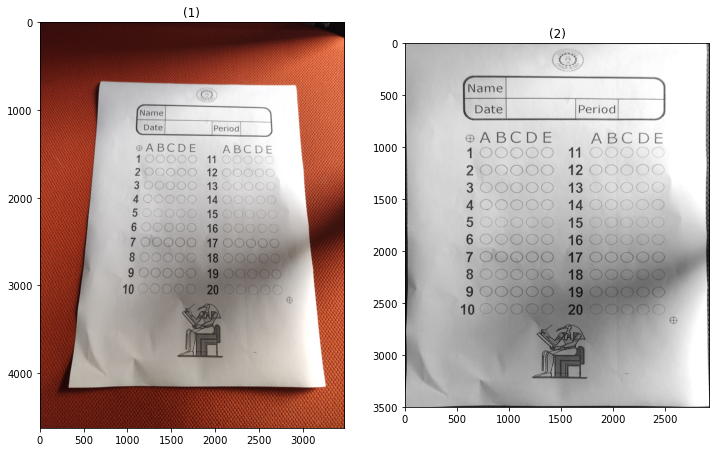

(252, 404)
(1110, 1200)


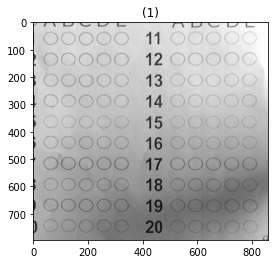

167


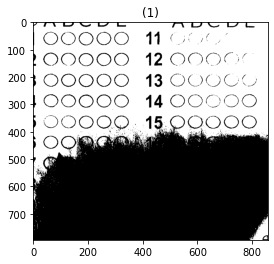

In [20]:
#trial
image_trial = io.imread('raw_imgs/image_raw10.jpg')
temp = io.imread("digital_images/bubbles_empty_with_cross_logo2.jpg")
paper,_ = perspective_correction(image_trial)
paper_gray = rgb2gray(paper)*255
paper_gray_resized = resize(paper_gray,(1600,1286))
paper_gray_resized = paper_gray_resized.astype("uint8")
print(paper_gray.shape)
print(image_trial.shape)
print(temp.shape)

print(type(paper_gray_resized[0][0]))

show_images([image_trial,paper_gray])
paper_cropped = crop_answers_section(paper_gray_resized)
show_images([paper_cropped])
thresh =threshold_otsu(paper_cropped)
print(thresh)
paper_cropped= paper_cropped>(thresh+10)
show_images([paper_cropped])